# Análise Completa PySpark — F1 (todos os CSVs)

Este notebook carrega todos os CSVs em `bronze/dados_originais` e executa EDA com PySpark: schema, contagens, duplicados, nulos/vazios, distintos, candidatos a chave, e gráficos (barras e scatter com regressão linear).

Observação: para gráficos usamos `toPandas()` apenas em resultados agregados ou amostras para evitar coletar dados enormes (ex.: `lap_times.csv`).

In [1]:
import os, sys, subprocess
from pyspark.sql import SparkSession

# garante que Spark vai usar o mesmo Python do driver
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

# se já tiver Spark rodando, para
prev = SparkSession.getActiveSession()
if prev is not None:
    prev.stop()

# cria sessão Spark
spark = (
    SparkSession.builder
    .master("local[*]")
    .appName("Bronze-Analytics")
    .config("spark.driver.extraJavaOptions", "-Djava.security.manager=allow")
    .config("spark.executor.extraJavaOptions", "-Djava.security.manager=allow")
    .getOrCreate()
)

spark.sparkContext.setLogLevel("ERROR")
print("Spark OK =>", spark.version)


25/09/24 18:41:41 WARN Utils: Your hostname, MacBook-Air-de-Kaleb.local resolves to a loopback address: 127.0.0.1; using 192.168.1.8 instead (on interface en0)
25/09/24 18:41:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/24 18:41:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark OK => 3.5.1


25/09/24 18:41:42 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
# Inicialização do Spark e utilidades
from pyspark.sql import SparkSession, functions as F, Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

import matplotlib.pyplot as plt
from pathlib import Path

spark = (SparkSession.builder.appName('F1-EDA-ALL-PySpark').getOrCreate())

def find_base_dir():
    cwd = Path.cwd()
    for p in [cwd, *cwd.parents]:
        candidate = p / 'bronze' / 'dados_originais'
        if candidate.exists():
            return candidate
    raise FileNotFoundError("Não encontrei 'bronze/dados_originais' a partir do diretório atual.")

BASE = find_base_dir()
BASE


PosixPath('/Users/kalebmacedo/formula1-analytics-1/bronze/dados_originais')

In [3]:
# Carregar todos os CSVs
csv_paths = sorted([p for p in BASE.glob('*.csv')])
dfs = {}  # nome_base -> DataFrame
for p in csv_paths:
    name = p.stem  # ex.: 'races'
    df = (
        spark.read.option('header', True).option('inferSchema', True).csv(str(p))
    )
    dfs[name] = df

sorted(list(dfs.keys()))


['circuits',
 'constructor_results',
 'constructor_standings',
 'constructors',
 'driver_standings',
 'drivers',
 'lap_times',
 'pit_stops',
 'qualifying',
 'races',
 'results',
 'seasons',
 'sprint_results',
 'status']

## Funções auxiliares de EDA e visualização

In [4]:
def contar_duplicados_linhas(df, total_rows=None, heavy_threshold=5_000_000):
    if total_rows is None:
        total_rows = df.count()
    if total_rows > heavy_threshold:
        # Evita operação muito pesada em datasets enormes
        return None
    unicos = df.dropDuplicates().count()
    return total_rows - unicos

def duplicados_por_chave(df, chaves, n=20):
    chaves = [c for c in chaves if c in df.columns]
    if not chaves:
        return None
    return df.groupBy(*chaves).count().where(F.col('count') > 1).orderBy(F.col('count').desc()).limit(n)

def contagem_nulos_vazios(df):
    exprs = []
    for c in df.columns:
        exprs.append(F.sum(F.col(c).isNull().cast('int')).alias(f'{c}__nulls'))
        exprs.append(F.sum((F.col(c).cast('string') == '').cast('int')).alias(f'{c}__empties'))
    return df.agg(*exprs)

def contagem_distintos(df):
    exprs = [F.countDistinct(c).alias(c) for c in df.columns]
    return df.agg(*exprs)

def candidatos_chave(df, total_rows=None):
    if total_rows is None:
        total_rows = df.count()
    dists = df.agg(*[F.countDistinct(c).alias(c) for c in df.columns]).collect()[0].asDict()
    # Colunas com 1 valor distinto por linha (potencial chave)
    return [c for c, d in dists.items() if d == total_rows]

def add_row_index(df, order_cols=None, idx_name='x_idx'):
    if order_cols is None:
        order_cols = df.columns
    win = Window.orderBy([F.col(c).asc_nulls_last() for c in order_cols])
    return df.withColumn(idx_name, F.row_number().over(win).cast('double'))

def first_string_col(df):
    for c, t in df.dtypes:
        if t in ('string',):
            return c
    return None

def numeric_cols(df):
    nums = []
    for c, t in df.dtypes:
        if t in ('int', 'bigint', 'double', 'float', 'long', 'short', 'decimal'):
            nums.append(c)
    return nums

def non_id_numeric_cols(df):
    ids = {'id'}
    cols = []
    for c in numeric_cols(df):
        if 'id' not in c.lower():
            cols.append(c)
    return cols or numeric_cols(df)

def plot_bar_from_spark(df, x_col, y_col, title, xlabel=None, ylabel=None, rot=45):
    rows = df.select(x_col, y_col).collect()
    xs = [r[x_col] for r in rows]
    ys = [float(r[y_col]) if r[y_col] is not None else 0.0 for r in rows]
    plt.figure(figsize=(10, 4))
    plt.bar(xs, ys, color='#4C78A8')
    plt.title(title)
    plt.xlabel(xlabel or x_col)
    plt.ylabel(ylabel or y_col)
    plt.xticks(rotation=rot)
    plt.tight_layout()
    plt.show()

def plot_pie_from_spark(df, label_col, value_col, title, top_k=10, other_label='Outros'):
    rows = df.select(label_col, value_col).orderBy(F.col(value_col).desc()).collect()
    labels = [r[label_col] for r in rows]
    values = [float(r[value_col]) if r[value_col] is not None else 0.0 for r in rows]
    if len(values) > top_k:
        top_labels = labels[:top_k]
        top_values = values[:top_k]
        other_sum = sum(values[top_k:])
        if other_sum > 0:
            top_labels.append(other_label)
            top_values.append(other_sum)
        labels, values = top_labels, top_values
    plt.figure(figsize=(6, 6))
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def scatter_hue_from_spark(df, x_col, y_col, hue_col, title, max_rows=20000, seed=42, top_hues=6):
    n = df.count()
    if n == 0:
        return
    frac = min(1.0, max_rows / float(n))
    sdf = df.sample(False, frac, seed) if n > max_rows else df

    # Reduz categorias raras para 'Outros'
    hue_counts = sdf.groupBy(hue_col).count().orderBy(F.col('count').desc())
    top_vals = [r[hue_col] for r in hue_counts.limit(top_hues).collect()]
    sdf2 = sdf.withColumn(
        hue_col, F.when(F.col(hue_col).isin(*top_vals), F.col(hue_col)).otherwise(F.lit('Outros'))
    )

    rows = sdf2.select(x_col, y_col, hue_col).collect()
    plt.figure(figsize=(8, 5))
    # Descobre categorias e atribui cores
    cats = []
    for r in rows:
        v = str(r[hue_col])
        if v not in cats:
            cats.append(v)
    cmap = plt.cm.get_cmap('tab10', max(1, len(cats)))
    data_by_cat = {c: ([], []) for c in cats}
    for r in rows:
        c = str(r[hue_col])
        xv = r[x_col]
        yv = r[y_col]
        if xv is not None and yv is not None:
            data_by_cat[c][0].append(float(xv))
            data_by_cat[c][1].append(float(yv))
    for i, c in enumerate(cats):
        xs, ys = data_by_cat[c]
        plt.scatter(xs, ys, s=10, alpha=0.6, color=cmap(i), label=c)
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.legend(title=hue_col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def iqr_outlier_bounds(df, col):
    # Usa approxQuantile para performance
    q1, q3 = df.approxQuantile(col, [0.25, 0.75], 0.01)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return lower, upper

def scatter_with_outliers(df, x_col, y_col, outlier_on_col, title, max_rows=20000, seed=42):
    n = df.count()
    if n == 0:
        return
    frac = min(1.0, max_rows / float(n))
    sdf = df.sample(False, frac, seed) if n > max_rows else df

    lower, upper = iqr_outlier_bounds(sdf, outlier_on_col)
    sdf2 = sdf.withColumn('is_outlier', (F.col(outlier_on_col) < lower) | (F.col(outlier_on_col) > upper))

    rows = sdf2.select(x_col, y_col, 'is_outlier').collect()
    in_x, in_y, out_x, out_y = [], [], [], []
    for r in rows:
        xv, yv, is_out = r[x_col], r[y_col], r['is_outlier']
        if xv is None or yv is None:
            continue
        if is_out:
            out_x.append(float(xv)); out_y.append(float(yv))
        else:
            in_x.append(float(xv)); in_y.append(float(yv))
    plt.figure(figsize=(8, 5))
    plt.scatter(in_x, in_y, s=10, alpha=0.5, color='#72B7B2', label='Normal')
    if len(out_x) > 0:
        plt.scatter(out_x, out_y, s=25, alpha=0.9, color='#E45756', marker='x', label='Outlier')
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.legend()
    plt.tight_layout()
    plt.show()

def scatter_com_regressao(df, y_col, order_cols=None, title=None, max_rows=5000, seed=42):
    # Amostragem para evitar coletar datasets enormes
    n = df.count()
    if n == 0:
        return None
    frac = min(1.0, max_rows / float(n))
    sdf = df.sample(withReplacement=False, fraction=frac, seed=seed) if n > max_rows else df

    df_idx = add_row_index(sdf.select(y_col), order_cols=order_cols, idx_name='x_idx')
    df_idx = df_idx.withColumn('label', F.col(y_col).cast('double')).dropna(subset=['label'])

    if df_idx.count() < 2:
        return None

    assembler = VectorAssembler(inputCols=['x_idx'], outputCol='features')
    feat_df = assembler.transform(df_idx).select('x_idx', 'label', 'features')

    lr = LinearRegression(featuresCol='features', labelCol='label')
    model = lr.fit(feat_df)
    pred = model.transform(feat_df).select('x_idx', 'label', 'prediction')

    r2 = getattr(model.summary, 'r2', None)
    slope = float(model.coefficients[0])
    pdf = pred.orderBy('x_idx').toPandas()
    plt.figure(figsize=(8, 4))
    plt.scatter(pdf['x_idx'], pdf['label'], s=10, alpha=0.6, color='#72B7B2', label='Dados (amostra)')
    plt.plot(pdf['x_idx'], pdf['prediction'], color='#F58518', linewidth=2, label='Regressão')
    ttl = title or f'Regressão linear: Y={y_col} vs X=índice'
    if r2 is not None:
        ttl += f' (slope={slope:.3f}, R²={r2:.3f})'
    plt.title(ttl)
    plt.xlabel('X = índice (amostra)')
    plt.ylabel(f'Y = {y_col}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return model

# Chaves conhecidas por dataset (usadas somente se colunas existirem)
KNOWN_KEYS = {
    'circuits': ['circuitId'],
    'constructors': ['constructorId', 'constructorRef'],
    'constructor_results': ['raceId', 'constructorId'],
    'constructor_standings': ['raceId', 'constructorId'],
    'driver_standings': ['raceId', 'driverId'],
    'drivers': ['driverId', 'driverRef'],
    'lap_times': ['raceId', 'driverId', 'lap'],
    'pit_stops': ['raceId', 'driverId', 'stop'],
    'qualifying': ['qualifyId'],
    'races': ['raceId'],
    'results': ['resultId'],
    'seasons': ['year'],
    'sprint_results': ['raceId', 'driverId'],
    'status': ['statusId'],
}


## EDA por dataset

Dataset: circuits
+---------+-----------+------------------------------+------------+---------+--------+-------+---+-----------------------------------------------------------+
|circuitId|circuitRef |name                          |location    |country  |lat     |lng    |alt|url                                                        |
+---------+-----------+------------------------------+------------+---------+--------+-------+---+-----------------------------------------------------------+
|1        |albert_park|Albert Park Grand Prix Circuit|Melbourne   |Australia|-37.8497|144.968|10 |http://en.wikipedia.org/wiki/Melbourne_Grand_Prix_Circuit  |
|2        |sepang     |Sepang International Circuit  |Kuala Lumpur|Malaysia |2.76083 |101.738|18 |http://en.wikipedia.org/wiki/Sepang_International_Circuit  |
|3        |bahrain    |Bahrain International Circuit |Sakhir      |Bahrain  |26.0325 |50.5106|7  |http://en.wikipedia.org/wiki/Bahrain_International_Circuit |
|4        |catalunya  |Circu

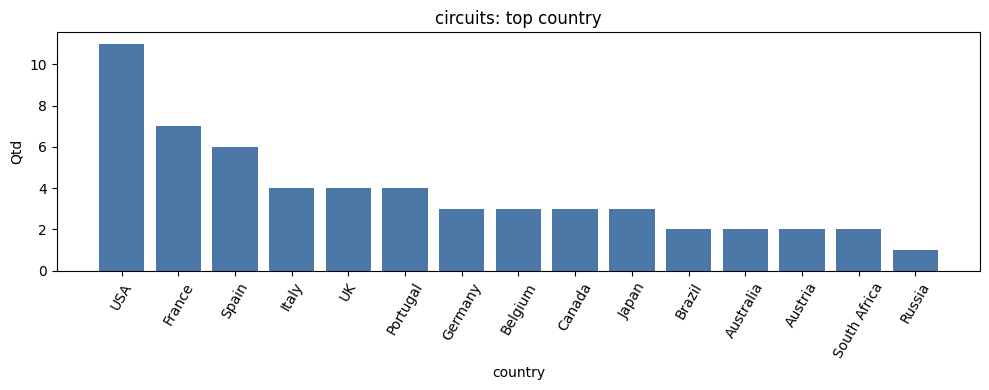

Falha no scatter/regressão: Pandas >= 1.0.5 must be installed; however, it was not found.
Dataset: constructor_results
+--------------------+------+-------------+------+------+
|constructorResultsId|raceId|constructorId|points|status|
+--------------------+------+-------------+------+------+
|1                   |18    |1            |14.0  |\N    |
|2                   |18    |2            |8.0   |\N    |
|3                   |18    |3            |9.0   |\N    |
|4                   |18    |4            |5.0   |\N    |
|5                   |18    |5            |2.0   |\N    |
+--------------------+------+-------------+------+------+
only showing top 5 rows

root
 |-- constructorResultsId: integer (nullable = true)
 |-- raceId: integer (nullable = true)
 |-- constructorId: integer (nullable = true)
 |-- points: double (nullable = true)
 |-- status: string (nullable = true)

Total de linhas: 12625
Duplicados de linha: 0
Duplicados por chave ['raceId', 'constructorId']:
+------+----------

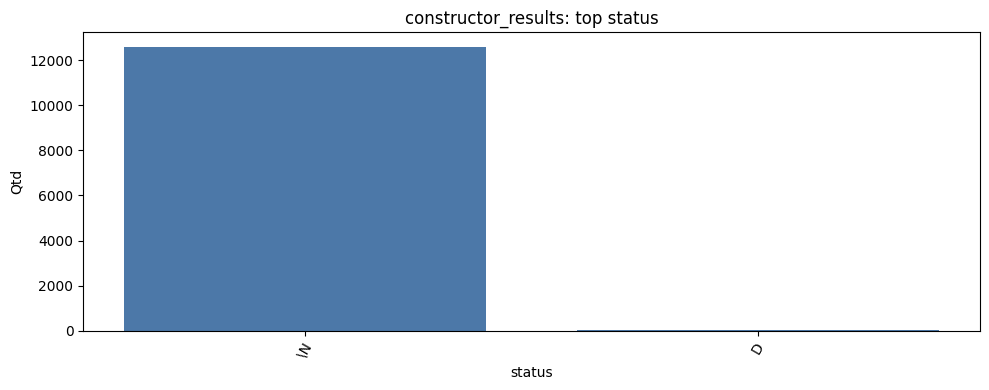

Falha no scatter/regressão: Pandas >= 1.0.5 must be installed; however, it was not found.
Dataset: constructor_standings
+----------------------+------+-------------+------+--------+------------+----+
|constructorStandingsId|raceId|constructorId|points|position|positionText|wins|
+----------------------+------+-------------+------+--------+------------+----+
|1                     |18    |1            |14.0  |1       |1           |1   |
|2                     |18    |2            |8.0   |3       |3           |0   |
|3                     |18    |3            |9.0   |2       |2           |0   |
|4                     |18    |4            |5.0   |4       |4           |0   |
|5                     |18    |5            |2.0   |5       |5           |0   |
+----------------------+------+-------------+------+--------+------------+----+
only showing top 5 rows

root
 |-- constructorStandingsId: integer (nullable = true)
 |-- raceId: integer (nullable = true)
 |-- constructorId: integer (nullab

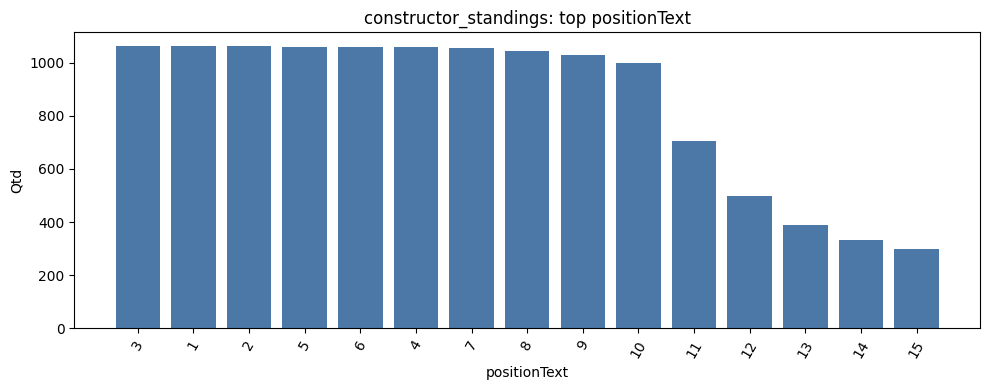

Falha no scatter/regressão: Pandas >= 1.0.5 must be installed; however, it was not found.
Dataset: constructors
+-------------+--------------+----------+-----------+------------------------------------------------------------+
|constructorId|constructorRef|name      |nationality|url                                                         |
+-------------+--------------+----------+-----------+------------------------------------------------------------+
|1            |mclaren       |McLaren   |British    |http://en.wikipedia.org/wiki/McLaren                        |
|2            |bmw_sauber    |BMW Sauber|German     |http://en.wikipedia.org/wiki/BMW_Sauber                     |
|3            |williams      |Williams  |British    |http://en.wikipedia.org/wiki/Williams_Grand_Prix_Engineering|
|4            |renault       |Renault   |French     |http://en.wikipedia.org/wiki/Renault_in_Formula_One         |
|5            |toro_rosso    |Toro Rosso|Italian    |http://en.wikipedia.org/wiki/S

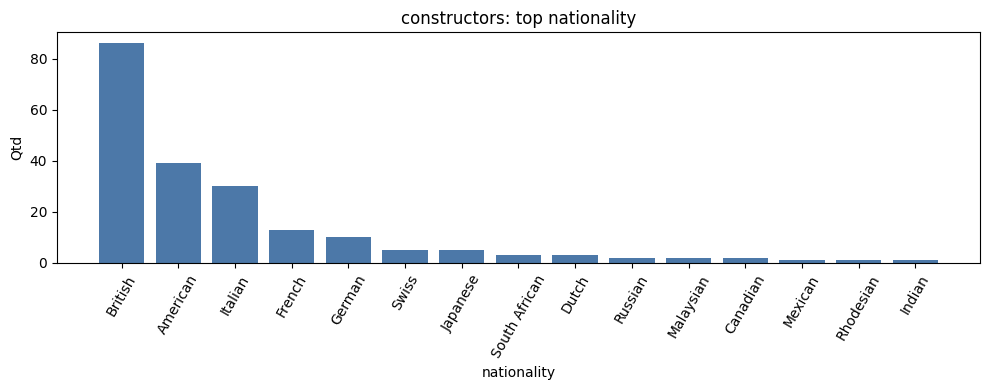

Falha no scatter/regressão: Pandas >= 1.0.5 must be installed; however, it was not found.
Dataset: driver_standings
+-----------------+------+--------+------+--------+------------+----+
|driverStandingsId|raceId|driverId|points|position|positionText|wins|
+-----------------+------+--------+------+--------+------------+----+
|1                |18    |1       |10.0  |1       |1           |1   |
|2                |18    |2       |8.0   |2       |2           |0   |
|3                |18    |3       |6.0   |3       |3           |0   |
|4                |18    |4       |5.0   |4       |4           |0   |
|5                |18    |5       |4.0   |5       |5           |0   |
+-----------------+------+--------+------+--------+------------+----+
only showing top 5 rows

root
 |-- driverStandingsId: integer (nullable = true)
 |-- raceId: integer (nullable = true)
 |-- driverId: integer (nullable = true)
 |-- points: double (nullable = true)
 |-- position: integer (nullable = true)
 |-- positionTe

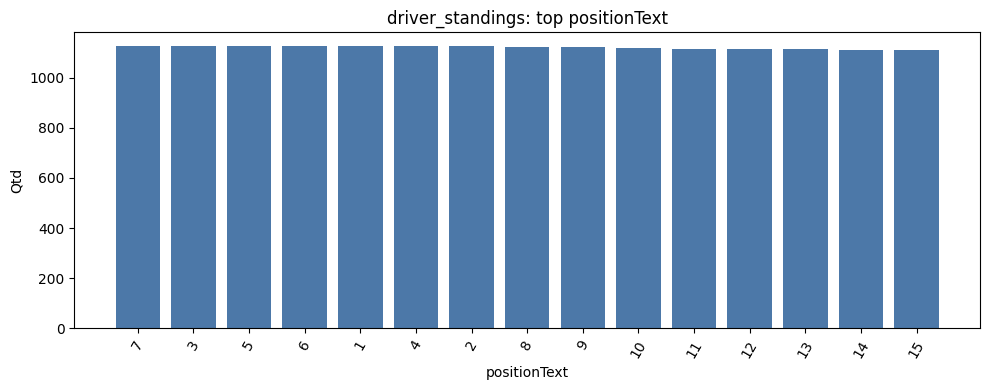

Falha no scatter/regressão: Pandas >= 1.0.5 must be installed; however, it was not found.
Dataset: drivers
+--------+----------+------+----+--------+----------+----------+-----------+----------------------------------------------+
|driverId|driverRef |number|code|forename|surname   |dob       |nationality|url                                           |
+--------+----------+------+----+--------+----------+----------+-----------+----------------------------------------------+
|1       |hamilton  |44    |HAM |Lewis   |Hamilton  |1985-01-07|British    |http://en.wikipedia.org/wiki/Lewis_Hamilton   |
|2       |heidfeld  |\N    |HEI |Nick    |Heidfeld  |1977-05-10|German     |http://en.wikipedia.org/wiki/Nick_Heidfeld    |
|3       |rosberg   |6     |ROS |Nico    |Rosberg   |1985-06-27|German     |http://en.wikipedia.org/wiki/Nico_Rosberg     |
|4       |alonso    |14    |ALO |Fernando|Alonso    |1981-07-29|Spanish    |http://en.wikipedia.org/wiki/Fernando_Alonso  |
|5       |kovalainen|\N  

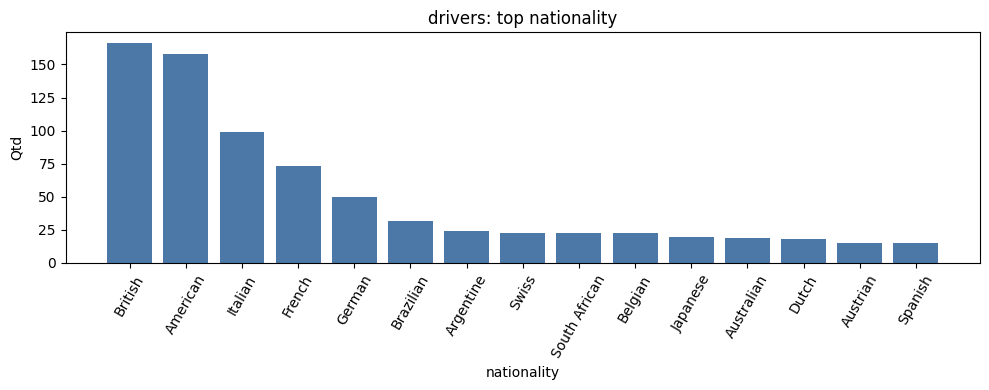

Falha no scatter/regressão: Pandas >= 1.0.5 must be installed; however, it was not found.
Dataset: lap_times
+------+--------+---+--------+--------+------------+
|raceId|driverId|lap|position|time    |milliseconds|
+------+--------+---+--------+--------+------------+
|841   |20      |1  |1       |1:38.109|98109       |
|841   |20      |2  |1       |1:33.006|93006       |
|841   |20      |3  |1       |1:32.713|92713       |
|841   |20      |4  |1       |1:32.803|92803       |
|841   |20      |5  |1       |1:32.342|92342       |
+------+--------+---+--------+--------+------------+
only showing top 5 rows

root
 |-- raceId: integer (nullable = true)
 |-- driverId: integer (nullable = true)
 |-- lap: integer (nullable = true)
 |-- position: integer (nullable = true)
 |-- time: string (nullable = true)
 |-- milliseconds: integer (nullable = true)

Total de linhas: 589081
Duplicados de linha: 0
Duplicados por chave ['raceId', 'driverId', 'lap']:
+------+--------+---+-----+
|raceId|driverId|l

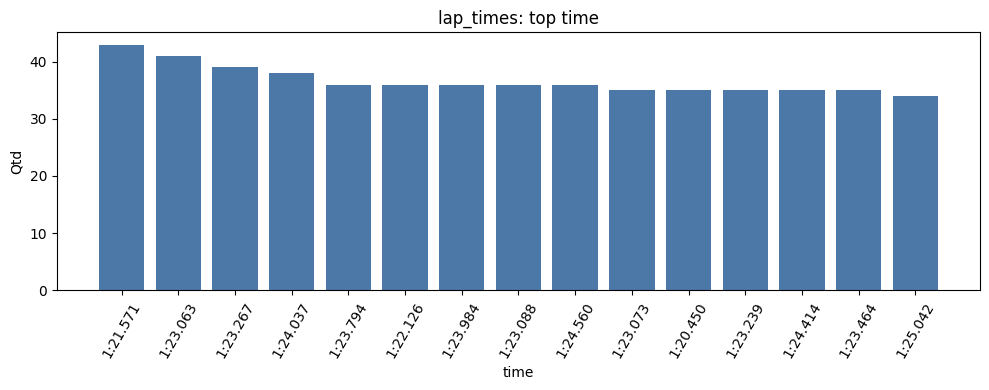

Falha no scatter/regressão: Pandas >= 1.0.5 must be installed; however, it was not found.
Dataset: pit_stops
+------+--------+----+---+-------------------+--------+------------+
|raceId|driverId|stop|lap|time               |duration|milliseconds|
+------+--------+----+---+-------------------+--------+------------+
|841   |153     |1   |1  |2025-09-24 17:05:23|26.898  |26898       |
|841   |30      |1   |1  |2025-09-24 17:05:52|25.021  |25021       |
|841   |17      |1   |11 |2025-09-24 17:20:48|23.426  |23426       |
|841   |4       |1   |12 |2025-09-24 17:22:34|23.251  |23251       |
|841   |13      |1   |13 |2025-09-24 17:24:10|23.842  |23842       |
+------+--------+----+---+-------------------+--------+------------+
only showing top 5 rows

root
 |-- raceId: integer (nullable = true)
 |-- driverId: integer (nullable = true)
 |-- stop: integer (nullable = true)
 |-- lap: integer (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- duration: string (nullable = true)
 |-- mil

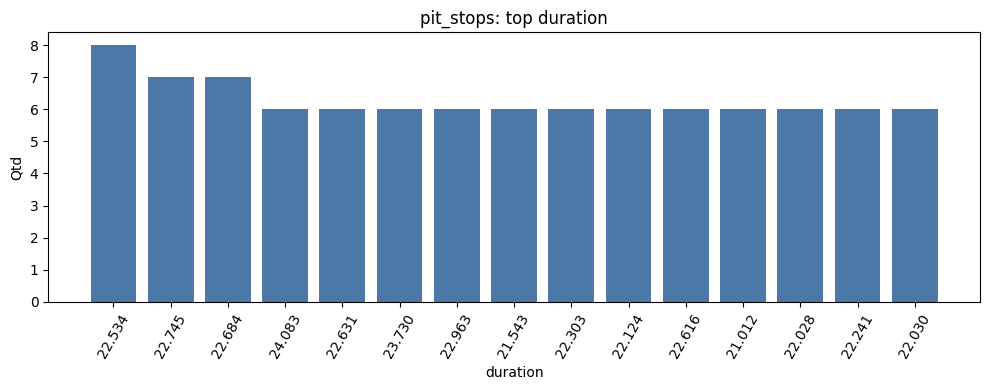

Falha no scatter/regressão: Pandas >= 1.0.5 must be installed; however, it was not found.
Dataset: qualifying
+---------+------+--------+-------------+------+--------+--------+--------+--------+
|qualifyId|raceId|driverId|constructorId|number|position|q1      |q2      |q3      |
+---------+------+--------+-------------+------+--------+--------+--------+--------+
|1        |18    |1       |1            |22    |1       |1:26.572|1:25.187|1:26.714|
|2        |18    |9       |2            |4     |2       |1:26.103|1:25.315|1:26.869|
|3        |18    |5       |1            |23    |3       |1:25.664|1:25.452|1:27.079|
|4        |18    |13      |6            |2     |4       |1:25.994|1:25.691|1:27.178|
|5        |18    |2       |2            |3     |5       |1:25.960|1:25.518|1:27.236|
+---------+------+--------+-------------+------+--------+--------+--------+--------+
only showing top 5 rows

root
 |-- qualifyId: integer (nullable = true)
 |-- raceId: integer (nullable = true)
 |-- driverId:

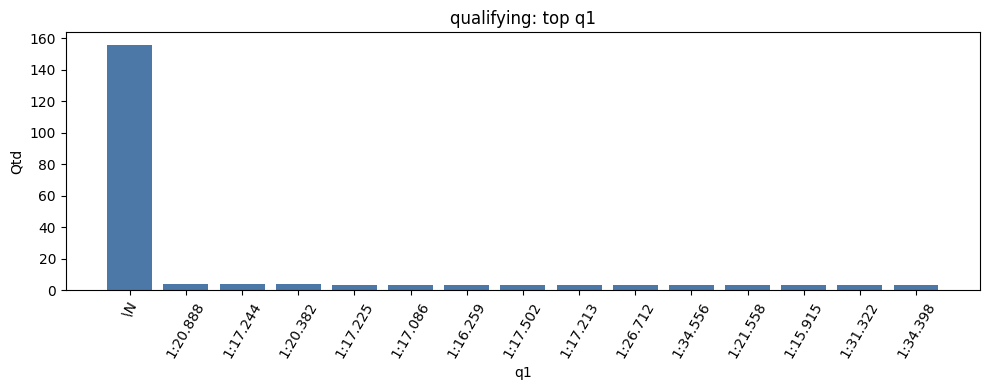

Falha no scatter/regressão: Pandas >= 1.0.5 must be installed; however, it was not found.
Dataset: races
+------+----+-----+---------+---------------------+----------+--------+-------------------------------------------------------+--------+--------+--------+--------+--------+--------+----------+----------+-----------+-----------+
|raceId|year|round|circuitId|name                 |date      |time    |url                                                    |fp1_date|fp1_time|fp2_date|fp2_time|fp3_date|fp3_time|quali_date|quali_time|sprint_date|sprint_time|
+------+----+-----+---------+---------------------+----------+--------+-------------------------------------------------------+--------+--------+--------+--------+--------+--------+----------+----------+-----------+-----------+
|1     |2009|1    |1        |Australian Grand Prix|2009-03-29|06:00:00|http://en.wikipedia.org/wiki/2009_Australian_Grand_Prix|\N      |\N      |\N      |\N      |\N      |\N      |\N        |\N        |\N      

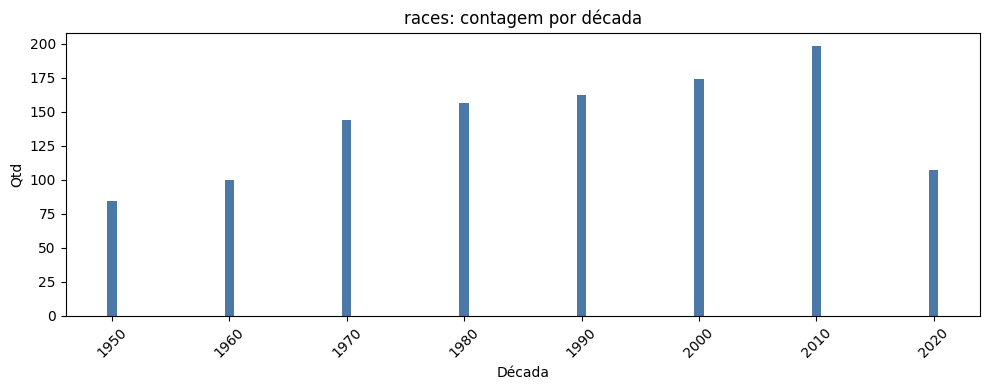

Falha no scatter/regressão: Pandas >= 1.0.5 must be installed; however, it was not found.
Dataset: results
+--------+------+--------+-------------+------+----+--------+------------+-------------+------+----+-----------+------------+----------+----+--------------+---------------+--------+
|resultId|raceId|driverId|constructorId|number|grid|position|positionText|positionOrder|points|laps|time       |milliseconds|fastestLap|rank|fastestLapTime|fastestLapSpeed|statusId|
+--------+------+--------+-------------+------+----+--------+------------+-------------+------+----+-----------+------------+----------+----+--------------+---------------+--------+
|1       |18    |1       |1            |22    |1   |1       |1           |1            |10.0  |58  |1:34:50.616|5690616     |39        |2   |1:27.452      |218.300        |1       |
|2       |18    |2       |2            |3     |5   |2       |2           |2            |8.0   |58  |+5.478     |5696094     |41        |3   |1:27.739      |217.586  

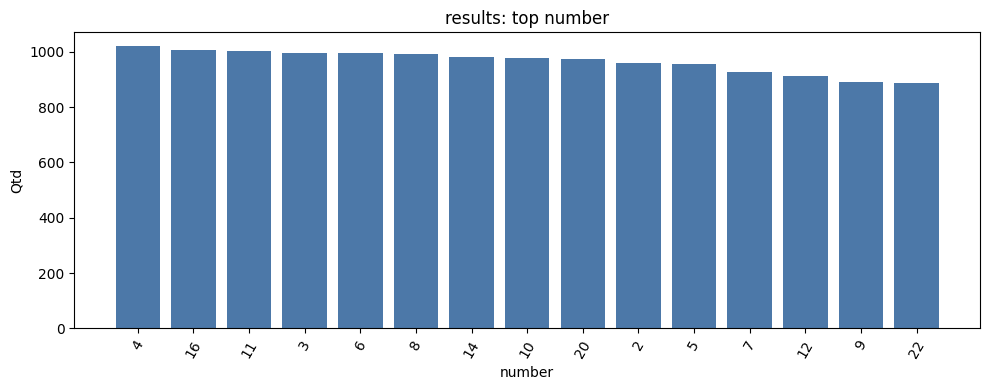

Falha no scatter/regressão: Pandas >= 1.0.5 must be installed; however, it was not found.
Dataset: seasons
+----+----------------------------------------------------+
|year|url                                                 |
+----+----------------------------------------------------+
|2009|http://en.wikipedia.org/wiki/2009_Formula_One_season|
|2008|http://en.wikipedia.org/wiki/2008_Formula_One_season|
|2007|http://en.wikipedia.org/wiki/2007_Formula_One_season|
|2006|http://en.wikipedia.org/wiki/2006_Formula_One_season|
|2005|http://en.wikipedia.org/wiki/2005_Formula_One_season|
+----+----------------------------------------------------+
only showing top 5 rows

root
 |-- year: integer (nullable = true)
 |-- url: string (nullable = true)

Total de linhas: 75
Duplicados de linha: 0
Duplicados por chave ['year']:
+----+-----+
|year|count|
+----+-----+
+----+-----+

Contagem de nulos/vazios por coluna:
+-----------+-------------+----------+------------+
|year__nulls|year__empties|url__nu

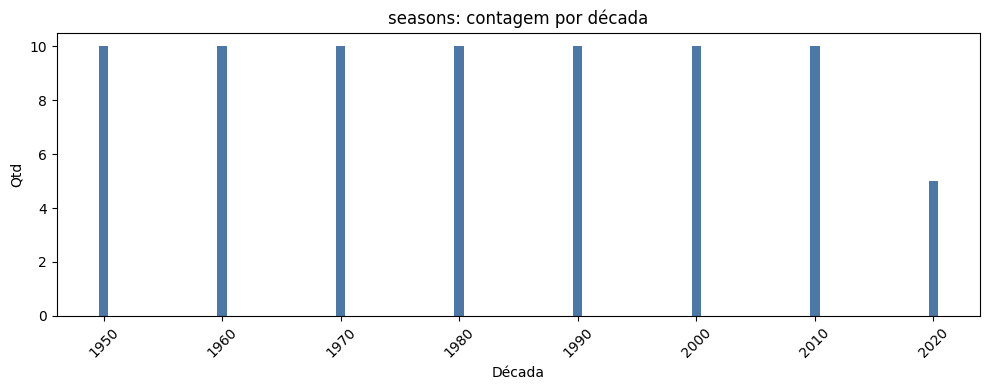

Falha no scatter/regressão: Pandas >= 1.0.5 must be installed; however, it was not found.
Dataset: sprint_results
+--------+------+--------+-------------+------+----+--------+------------+-------------+------+----+---------+------------+----------+--------------+--------+
|resultId|raceId|driverId|constructorId|number|grid|position|positionText|positionOrder|points|laps|time     |milliseconds|fastestLap|fastestLapTime|statusId|
+--------+------+--------+-------------+------+----+--------+------------+-------------+------+----+---------+------------+----------+--------------+--------+
|1       |1061  |830     |9            |33    |2   |1       |1           |1            |3     |17  |25:38.426|1538426     |14        |1:30.013      |1       |
|2       |1061  |1       |131          |44    |1   |2       |2           |2            |2     |17  |+1.430   |1539856     |17        |1:29.937      |1       |
|3       |1061  |822     |131          |77    |3   |3       |3           |3            |1  

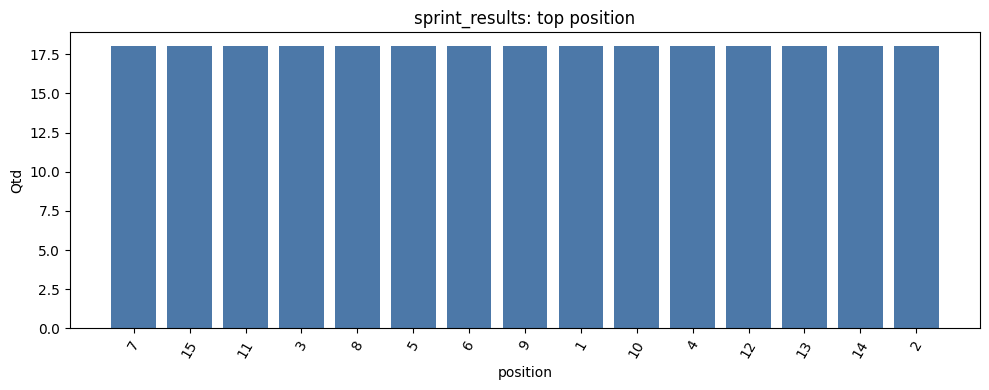

Falha no scatter/regressão: Pandas >= 1.0.5 must be installed; however, it was not found.
Dataset: status
+--------+------------+
|statusId|status      |
+--------+------------+
|1       |Finished    |
|2       |Disqualified|
|3       |Accident    |
|4       |Collision   |
|5       |Engine      |
+--------+------------+
only showing top 5 rows

root
 |-- statusId: integer (nullable = true)
 |-- status: string (nullable = true)

Total de linhas: 139
Duplicados de linha: 0
Duplicados por chave ['statusId']:
+--------+-----+
|statusId|count|
+--------+-----+
+--------+-----+

Contagem de nulos/vazios por coluna:
+---------------+-----------------+-------------+---------------+
|statusId__nulls|statusId__empties|status__nulls|status__empties|
+---------------+-----------------+-------------+---------------+
|0              |0                |0            |0              |
+---------------+-----------------+-------------+---------------+

Contagem de distintos por coluna:
+--------+------+


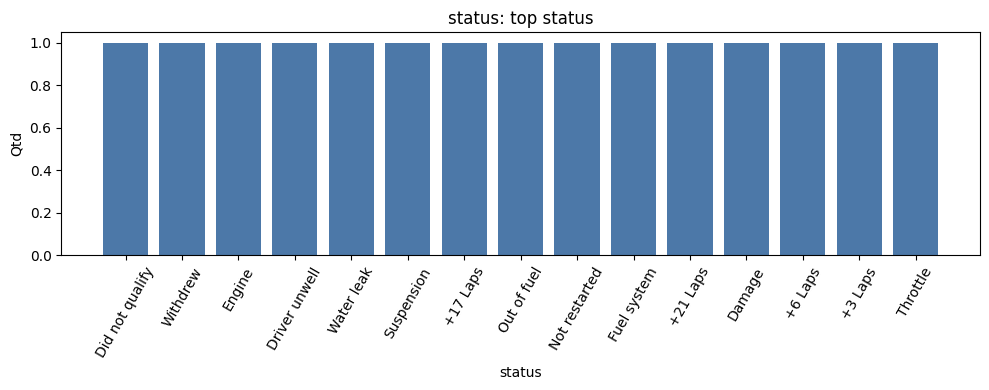

Falha no scatter/regressão: Pandas >= 1.0.5 must be installed; however, it was not found.


In [5]:
for name, df in dfs.items():
    print('='*100)
    print(f'Dataset: {name}')
    df.show(5, truncate=False)
    df.printSchema()

    total = df.count()
    print('Total de linhas:', total)

    dup_rows = contar_duplicados_linhas(df, total_rows=total)
    if dup_rows is None:
        print('Duplicados de linha: ignorado (dataset muito grande)')
    else:
        print('Duplicados de linha:', dup_rows)

    keys = KNOWN_KEYS.get(name, [])
    dup_key_df = duplicados_por_chave(df, keys) if keys else None
    if dup_key_df is not None:
        print(f'Duplicados por chave {keys}:')
        dup_key_df.show(truncate=False)

    print('Contagem de nulos/vazios por coluna:')
    contagem_nulos_vazios(df).show(truncate=False)

    print('Contagem de distintos por coluna:')
    contagem_distintos(df).show(truncate=False)

    # Candidatos a chave (colunas com todos os valores distintos)
    try:
        cands = candidatos_chave(df, total_rows=total)
        print('Candidatos a chave (countDistinct == total):', cands)
    except Exception as e:
        print('Candidatos a chave: não calculado ->', e)

    # Resumos numéricos
    num_cols = numeric_cols(df)
    if num_cols:
        print('Resumo numérico (describe) para colunas:', num_cols[:6], '...')
        df.select(*num_cols).describe().show(truncate=False)

    # Checagens específicas simples
    if 'year' in df.columns:
        df.select(F.min('year').alias('min_year'), F.max('year').alias('max_year')).show()
    if 'url' in df.columns:
        df.select(
            F.count(F.when(F.col('url').isNull() | (F.col('url') == ''), 1)).alias('urls_vazias'),
            F.count(F.when(~F.col('url').rlike('^https?://'), 1)).alias('urls_nao_http')
        ).show()

    # Visualizações: barra + regressão (se possível)
    # Barra: tenta usar uma coluna categórica mais óbvia
    bar_done = False
    if 'year' in df.columns:
        # Barras por década
        decade_df = (df.withColumn('decade', (F.col('year')/10).cast('int')*10)
                     .groupBy('decade').count().orderBy('decade'))
        try:
            plot_bar_from_spark(decade_df, 'decade', 'count', f'{name}: contagem por década', 'Década', 'Qtd')
            bar_done = True
        except Exception as e:
            print('Falha no gráfico de barras por década:', e)
    if not bar_done:
        cat_col = None
        # Preferências de colunas categóricas:
        for pref in ['nationality', 'country', 'name', 'status', first_string_col(df)]:
            if pref and pref in df.columns:
                cat_col = pref
                break
        if cat_col:
            top_cat = df.groupBy(cat_col).count().orderBy(F.col('count').desc()).limit(15)
            try:
                plot_bar_from_spark(top_cat, cat_col, 'count', f'{name}: top {cat_col}', cat_col, 'Qtd', rot=60)
            except Exception as e:
                print('Falha no gráfico de barras:', e)

    # Scatter + regressão
    y_col = None
    non_id_nums = non_id_numeric_cols(df)
    if non_id_nums:
        y_col = non_id_nums[0]
    elif num_cols:
        y_col = num_cols[0]
    if y_col:
        try:
            _ = scatter_com_regressao(df, y_col=y_col, order_cols=[y_col], title=f'{name}: regressão (índice vs {y_col})', max_rows=5000)
        except Exception as e:
            print('Falha no scatter/regressão:', e)


## Gráficos avançados (Requeridos)

In [6]:
# Bases necessárias
results = dfs.get('results')
status = dfs.get('status')
constructors = dfs.get('constructors')
constructor_standings = dfs.get('constructor_standings')

assert results is not None and status is not None and constructors is not None

# Enriquecimento: junta status ao results
res_enriched = (
    results.join(status, on='statusId', how='left')
)
res_enriched = res_enriched.withColumn('grid', F.col('grid').cast('double')) \
    .withColumn('positionOrder', F.col('positionOrder').cast('double'))
res_enriched = res_enriched.where(F.col('grid').isNotNull() & F.col('positionOrder').isNotNull())

# Medida para outliers na relação grid x posição final
res_enriched = res_enriched.withColumn('pos_delta', F.col('positionOrder') - F.col('grid'))
res_enriched.cache()
res_enriched.count()  # materializa cache


26759

### Scatter com categorias (hue): grid x posição final (colorido por status)

/var/folders/b0/q2nmc0t50q1g61pqr88_7pcm0000gn/T/ipykernel_20145/4240406498.py:114: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', max(1, len(cats)))


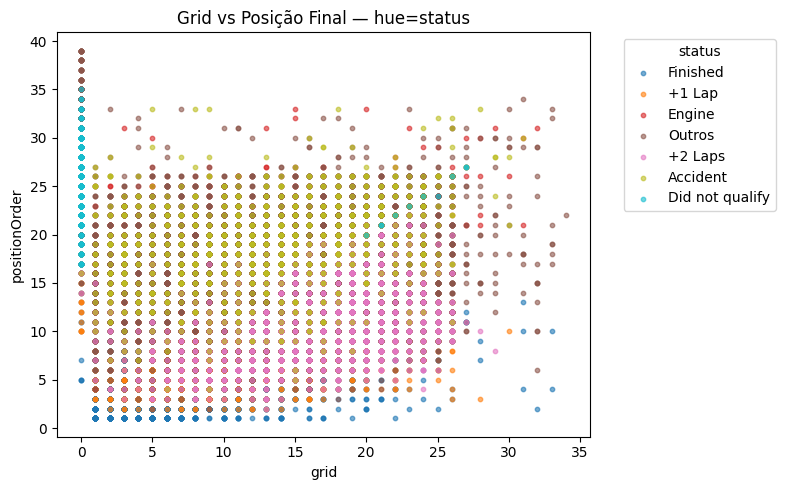

In [7]:
scatter_hue_from_spark(
    res_enriched,
    x_col='grid',
    y_col='positionOrder',
    hue_col='status',
    title='Grid vs Posição Final — hue=status'
)


### Outliers: grid x posição final (baseado em IQR de pos_delta)

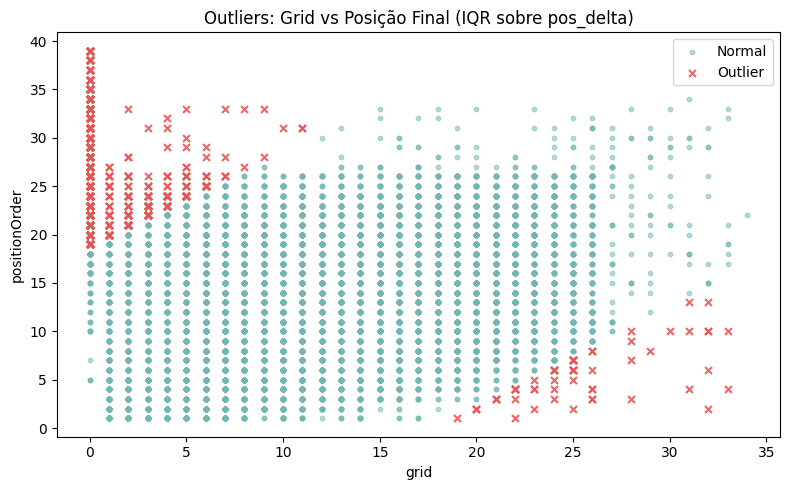

In [8]:
scatter_with_outliers(
    res_enriched,
    x_col='grid',
    y_col='positionOrder',
    outlier_on_col='pos_delta',
    title='Outliers: Grid vs Posição Final (IQR sobre pos_delta)'
)


### Regressão linear: posição final vs grid (linha reta)

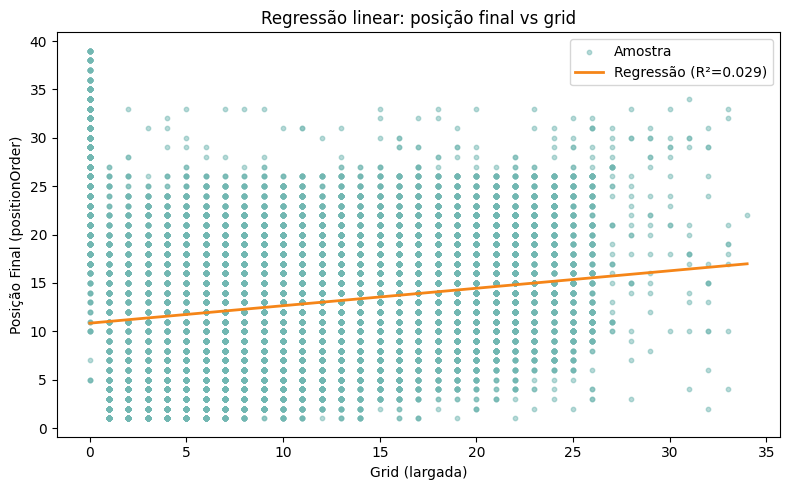

In [9]:
# Prepara dados para regressão
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

reg_df = res_enriched.select('grid', 'positionOrder').dropna()
n = reg_df.count()
frac = min(1.0, 20000 / float(n)) if n else 0.0
reg_sdf = reg_df.sample(False, frac, 42) if n > 20000 else reg_df

assembler = VectorAssembler(inputCols=['grid'], outputCol='features')
feat = assembler.transform(reg_sdf).withColumnRenamed('positionOrder', 'label')
lr = LinearRegression(featuresCol='features', labelCol='label')
model = lr.fit(feat)
slope = float(model.coefficients[0])
intercept = float(model.intercept)
r2 = getattr(model.summary, 'r2', None)

# Plot com linha de regressão (sem pandas)
x_min, x_max = reg_sdf.agg(F.min('grid'), F.max('grid')).first()
rows = reg_sdf.select('grid', 'positionOrder').collect()
xs = [float(r['grid']) for r in rows if r['grid'] is not None]
ys = [float(r['positionOrder']) for r in rows if r['positionOrder'] is not None]
steps = 100
x_line = [x_min + (x_max - x_min) * i/(steps-1) for i in range(steps)] if x_min is not None and x_max is not None else []
y_line = [slope * x + intercept for x in x_line]

plt.figure(figsize=(8,5))
plt.scatter(xs, ys, s=10, alpha=0.5, color='#72B7B2', label='Amostra')
if x_line:
    plt.plot(x_line, y_line, color='#F58518', linewidth=2, label=f'Regressão (R²={r2:.3f})' if r2 is not None else 'Regressão')
plt.title('Regressão linear: posição final vs grid')
plt.xlabel('Grid (largada)')
plt.ylabel('Posição Final (positionOrder)')
plt.legend()
plt.tight_layout()
plt.show()


### Pizza: distribuição de status (Finished, DNF, etc.)

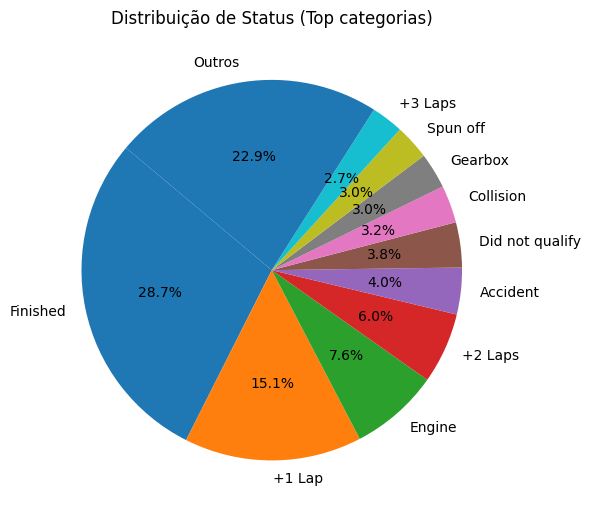

In [10]:
status_dist = results.groupBy('statusId').count().alias('cnt')
status_named = status_dist.join(status, on='statusId', how='left').select('status', 'count')
plot_pie_from_spark(status_named, 'status', 'count', 'Distribuição de Status (Top categorias)')


### Barras (barplot): Top-10 construtores por pontos

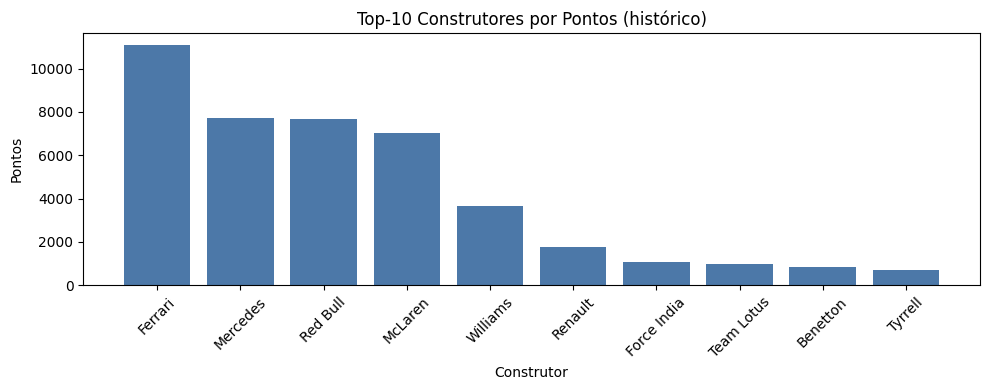

In [11]:
# Soma de pontos em 'results' por construtor ao longo do histórico
cons_points = (
    results.withColumn('points', F.col('points').cast('double'))
           .groupBy('constructorId').agg(F.sum('points').alias('total_points'))
)
cons_points_named = (
    cons_points.join(constructors.select('constructorId', 'name'), on='constructorId', how='left')
)
top10 = cons_points_named.orderBy(F.col('total_points').desc()).limit(10)
plot_bar_from_spark(top10.orderBy(F.col('total_points').desc()), 'name', 'total_points', 'Top-10 Construtores por Pontos (histórico)', 'Construtor', 'Pontos', rot=45)


## Exemplos de limpeza (PySpark)

Estas transformações são exemplos e podem ser adaptadas conforme a necessidade.

In [13]:
# Remover duplicados por chaves conhecidas, se existirem
dedup_dfs = {}
for name, df in dfs.items():
    keys = [k for k in KNOWN_KEYS.get(name, []) if k in df.columns]
    if keys:
        dedup_dfs[name] = df.dropDuplicates(keys)
    else:
        dedup_dfs[name] = df

# Normalizações simples de strings em alguns datasets
if 'constructors' in dedup_dfs:
    constructors_clean = (dedup_dfs['constructors']
        .withColumn('name', F.trim(F.col('name')))
        .withColumn('nationality', F.trim(F.col('nationality')))
        .withColumn('url', F.when((F.col('url') == '') | F.col('url').isNull(), F.lit(None)).otherwise(F.col('url')))
    )
    constructors_clean.show(5)

if 'drivers' in dedup_dfs:
    drivers_clean = (dedup_dfs['drivers']
        .withColumn('code', F.upper(F.trim(F.col('code'))))
    )
    drivers_clean.show(5)


+-------------+--------------+----------+-----------+--------------------+
|constructorId|constructorRef|      name|nationality|                 url|
+-------------+--------------+----------+-----------+--------------------+
|            1|       mclaren|   McLaren|    British|http://en.wikiped...|
|            2|    bmw_sauber|BMW Sauber|     German|http://en.wikiped...|
|            3|      williams|  Williams|    British|http://en.wikiped...|
|            4|       renault|   Renault|     French|http://en.wikiped...|
|            5|    toro_rosso|Toro Rosso|    Italian|http://en.wikiped...|
+-------------+--------------+----------+-----------+--------------------+
only showing top 5 rows

+--------+----------+------+----+--------+----------+----------+-----------+--------------------+
|driverId| driverRef|number|code|forename|   surname|       dob|nationality|                 url|
+--------+----------+------+----+--------+----------+----------+-----------+--------------------+
|     